In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
from astropy.io import fits
from tqdm import tqdm

import myUtils
import deepsource as ds


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_path = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync'
keys = np.load(os.path.join(data_path, "Sources_detection/sky_keys.npy"))
indices_validation = np.load(os.path.join(data_path, "Sources_detection/seed_0/validation_idx.npy"))
indices_test = np.load(os.path.join(data_path, "Sources_detection/seed_0/test_idx.npy"))

print("Numbber of keys: ", len(keys))
print("Lenght validation set: ", len(indices_validation))
print("Lenght test set: ", len(indices_test))

Numbber of keys:  9164
Lenght validation set:  917
Lenght test set:  916


In [3]:
# List of images paths regarding the train, validation and test set
validation_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_validation]
test_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_test]

print("Lenght validation set: ", len(validation_images_path))
print("Lenght test set: ", len(test_images_path))

Lenght validation set:  917
Lenght test set:  916


In [19]:
# List of images paths regarding the train, validation and test set
validation_noisy_images_path = [os.path.join(data_path, 'clean_noisy', "clean_noisy_gaussians_" + keys[ind] + ".fits") for ind in indices_validation]
test_noisy_images_path = [os.path.join(data_path, 'clean_noisy', "clean_noisy_gaussians_" + keys[ind] + ".fits") for ind in indices_test]

print("Lenght validation set: ", len(validation_noisy_images_path))
print("Lenght test set: ", len(test_noisy_images_path))

Lenght validation set:  917
Lenght test set:  916


In [5]:
validation_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_validation, keys)
test_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_test, keys)
print("Lenght validation set: ", len(validation_RealDetection))
print("Lenght test set: ", len(test_RealDetection))

# compute the pixels index of ground truth positions
validation_RealDetection_px = [myUtils.RaDec2pixels(validation_RealDetection[ind], fits.getheader(validation_images_path[ind])) for ind in tqdm(range(len(validation_RealDetection)))]
test_RealDetection_px = [myUtils.RaDec2pixels(test_RealDetection[ind], fits.getheader(test_images_path[ind])) for ind in tqdm(range(len(test_RealDetection)))]

print()
print(np.array(test_RealDetection_px[0]).shape)
print(np.array(test_RealDetection_px[1]).shape)
print(np.array(test_RealDetection_px[2]).shape)

Lenght validation set:  917
Lenght test set:  916


100%|██████████| 916/916 [00:04<00:00, 215.26it/s]


(2, 2)
(2, 3)
(2, 5)


100%|██████████| 916/916 [00:03<00:00, 259.74it/s]


shape validation input:  (917, 512, 512)
shape test input:  (916, 512, 512)


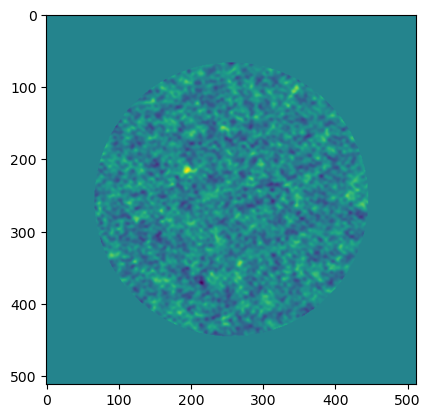

In [21]:
# open fits files from validation_images_path and store them into a tensor validation_input
validation_input = [fits.getdata(validation_noisy_images_path[ind])[0,0] for ind in tqdm(range(len(validation_noisy_images_path)))]
validation_input = np.nan_to_num(np.array(validation_input), nan=0)

# open fits files from test_images_path and store them into a tensor test_input
test_input = [fits.getdata(test_noisy_images_path[ind])[0,0] for ind in tqdm(range(len(test_noisy_images_path)))]
test_input = np.nan_to_num(np.array(test_input), nan=0)

print("shape validation input: ", validation_input.shape)
print("shape test input: ", test_input.shape)
plt.figure()
plt.imshow(validation_input[1])
plt.show()

In [7]:
listRealDetection_test = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_test, keys)
listRealDetection_validation = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_validation, keys)
print(len(listRealDetection_test))
print(len(listRealDetection_validation))

916
917


In [10]:
writingModelFile_path = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/modelDeepSource/models_validation'
myUtils.writingModel(writingModelFile_path, listRealDetection_validation, 'clean_gaussians_', indices_validation, keys)

In [11]:
models_validation_path = []   # list containing all the fits file path for the test 

for ind in indices_validation:
    key = keys[ind]

    data = os.path.join(writingModelFile_path, "clean_gaussians_" + key + ".txt")
    models_validation_path.append(data)
len(models_validation_path)


917

In [23]:
def kernels(cat):
    out = ds.horn_kernel(cat,radius=10,step_height=2)
    return ds.gaussian_kernel(out,sigma=7)

patch_size = 510

ppdp = ds.GeneralDataProvider(images_path=validation_noisy_images_path,models_path=models_validation_path, margin=0, nx=510, ny=510,kernels=kernels, b_n=0.05, alpha=0)

model_add = './cmodel'
restore = os.path.exists(model_add)

cnn = ds.ConvolutionalLayers(nx=patch_size,n_channel=1,restore=restore,model_add=model_add,arch_file_name='arch')

cnn.train(ppdp,training_epochs=1,learning_rate = 0.01,n_s=1,dropout=0.2,verbose=10)


number of files:  917 , number of channels:  1
INFO:tensorflow:Restoring parameters from ./cmodel/model


Epoch:0, cost= 547.432622


In [190]:
%%capture
listDetectedSources = []
for i in tqdm(range(len(validation_noisy_images_path))):
    image_file = validation_noisy_images_path[i]
    model_file = models_validation_path[i]
    catalog = ds.ps_extract(image_file,model_file,cnn,ds.fetch_data,loc_det='mean',ignore_border=150,jump_lim=3,area_lim=50,threshold_0=1.,lw=510,pad=10,verbose=False,useNetwork=False)
    listDetectedSources.append(catalog[:,:2].T)

In [191]:
resAllComparison = myUtils.compareRealAndDetectedSources_pixels(listDetectedSources, validation_RealDetection_px)
print("Result (TP, FP, FN): ", resAllComparison)

Result (TP, FP, FN):  [ 970   71 1800]


In [192]:
purityAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[1])
CompletnessAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[2])
print("Purity: ", purityAll)
print("Completness: ", CompletnessAll)

Purity:  0.9317963496637848
Completness:  0.35018050541516244


# apply on noiseless


In [193]:
%%capture
listDetectedSources = []
for i in tqdm(range(len(validation_images_path))):
    image_file = validation_images_path[i]
    model_file = models_validation_path[i]
    catalog = ds.ps_extract(image_file,model_file,cnn,ds.fetch_data,loc_det='mean',ignore_border=150,jump_lim=3,area_lim=50,threshold_0=1.,lw=510,pad=10,verbose=False,useNetwork=False)
    listDetectedSources.append(catalog[:,:2].T)

In [194]:
resAllComparison = myUtils.compareRealAndDetectedSources_pixels(listDetectedSources, validation_RealDetection_px)
print("Result (TP, FP, FN): ", resAllComparison)

Result (TP, FP, FN):  [2565 5721  205]


In [195]:
purityAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[1])
CompletnessAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[2])
print("Purity: ", purityAll)
print("Completness: ", CompletnessAll)

Purity:  0.3095582910934106
Completness:  0.9259927797833934
